In [1]:
import random
import os
import urllib3
import pandas as pd
import geopandas as gpd
from geopy import distance
import matplotlib.pyplot as plt
import numpy as np

COMMON_DIR = os.path.join(os.pardir, 'common')
sys.path.insert(1, COMMON_DIR)

from madison_coordinates import madisonCoordinateToLatLon
import data_retreiver
print(dir(data_retreiver))

['DATASETS', 'DATA_PATH', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'download_datasets', 'download_file', 'load_csv_datasets', 'os', 'pd', 'urllib3']


In [2]:
data_retreiver.download_datasets()

MaxRetryError: HTTPSConnectionPool(host='raw.githubusercontent.com', port=443): Max retries exceeded with url: /madison-housing-cs638/data/master/all_parcel_raw.csv (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f738421c880>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

In [5]:
(core, core_single_family) = data_retreiver.load_csv_datasets("all_parcel_core", "single_family_core")
core_single_family

XRefParcel                Address PropertyClass    PropertyUse  \
Parcel                                                                         
71002302108  71002302108      102 North Star Dr   Residential  Single family   
71002302116  71002302116      104 North Star Dr   Residential  Single family   
71002302124  71002302124      106 North Star Dr   Residential  Single family   
71002302132  71002302132      108 North Star Dr   Residential  Single family   
71002303015  71002303015          111 Milky Way   Residential  Single family   
...                  ...                    ...           ...            ...   
71001416124  71001416124  7121 Field Flower Way   Residential  Single family   
71001416132  71001416132  7127 Field Flower Way   Residential  Single family   
71001416140  71001416140  7133 Field Flower Way   Residential  Single family   
71002102029  71002102029      6002 Milwaukee St   Residential  Single family   
71002102061  71002102061      6302 Milwaukee St   Residential  Single family   

             AssessmentArea MoreThanOneBuild         HomeStyle  YearBuilt  \
Parcel                                                                      
71002302108             115              NaN  Townhouse Duplex       2019   
71002302116             115              NaN  Townhouse Duplex       2019   
71002302124             115              NaN         Townhouse       2019   
71002302132             115              NaN         Townhouse       2019   
71002303015              99              NaN  Modern two story       2016   
...                     ...              ...               ...        ...   
71001416124             103              NaN             Ranch       2018   
71001416132             103              NaN             Ranch       2018   
71001416140             103              NaN             Ranch       2018   
71002102029             115              NaN             Ranch       1979   
71002102061             115              NaN             Ranch       1963   

             Bedrooms  FullBaths  ...       YCoord   SHAPESTArea  \
Parcel                            ...                              
71002302108         3          2  ...  491732.1595   6510.124695   
71002302116         3          2  ...  491690.1742   3543.940063   
71002302124         3          2  ...  491660.6293   3543.940002   
71002302132         3          2  ...  491628.4275   4134.488586   
71002303015         3          2  ...  491488.2448   3856.628784   
...               ...        ...  ...          ...           ...   
71001416124         3          2  ...  491873.8551   7958.260986   
71001416132         3          2  ...  491908.7014   7962.450867   
71001416140         3          2  ...  491951.7501   8913.302704   
71002102029         3          1  ...  491925.2916  21736.705350   
71002102061         4          2  ...  492055.7620  41155.943420   

             SHAPESTLength        lat        lon       property_kind  \
Parcel                                                                 
71002302108     339.114756  43.099129 -89.276046  single_family_home   
71002302116     299.365542  43.099014 -89.276044  single_family_home   
71002302124     299.365542  43.098933 -89.276046  single_family_home   
71002302132     301.805554  43.098844 -89.276054  single_family_home   
71002303015     284.553221  43.098459 -89.279057  single_family_home   
...                    ...        ...        ...                 ...   
71001416124     364.028490  43.099518 -89.250960  single_family_home   
71001416132     365.173818  43.099613 -89.250718  single_family_home   
71001416140     381.457545  43.099732 -89.250479  single_family_home   
71002102029     602.175248  43.099659 -89.274975  single_family_home   
71002102061     806.767740  43.100017 -89.270427  single_family_home   

             industrial_sites_near  commercial_sites_near  vacant_sites_near  \
Parcel                                                               

### property_kind:
I needed a better way to definaitively seperate all the parcels into some distinct groups.
* Single Family
    * `raw["PropertyClass"] == "Residential", raw["PropertyUse"] == "Single Family"`
* Industrial
    * `raw["PropertyClass"] == "Industrial", raw["PropertyUse"] == "Manufacturing"`
* Appartment
    * Has "unit" in `raw["PropertyUse"]`
* Commercial (Non-Appartment)
    * `raw["PropertyClass"] == "Commercial"` AND not in any other class.
* Agricultural
    * `raw["PropertyClass"] == "Agricultural", raw["PropertyUse"] == "Agricultural"`
* Vacant
    * Has "vacant" in `raw["PropertyUse"]`

<Figure size 432x288 with 0 Axes>

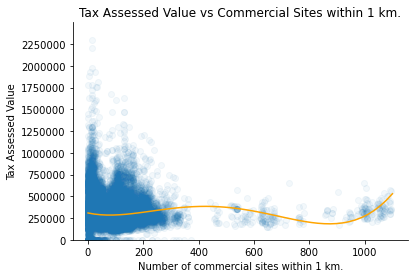

In [27]:
#Code for the regression line.
plt.tight_layout()


reasonable_filt = core_single_family["Total_Assessment"] < 750000
reasonable = core_single_family[reasonable_filt]

use_reasonable = False
target_variable = "commercial_sites_near"
target = reasonable if use_reasonable else core_single_family


coef = np.polyfit(target[target_variable].values, target["Total_Assessment"].values, deg=4)
poly = np.poly1d(coef)
prediction_Xs = np.linspace(0, 1100, 50)
y_pred = poly(prediction_Xs)

fig, ax = plt.subplots()
ax.set_yticks(np.arange(0, 2500000, 250000))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_title("Tax Assessed Value vs Commercial Sites within 1 km.")
ax.set_ylabel("Tax Assessed Value")
ax.set_xlabel("Number of commercial sites within 1 km.")
ax.set_ylim(0, 2500000)
ax.scatter(target[target_variable], target["Total_Assessment"], alpha=0.05)

#plot the regression line.
ax.plot(prediction_Xs, y_pred, color="orange")
fig.savefig("groop_smol.png", dpi=300, bbox_inches = "tight")